# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 03/17/2025

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GP_trained_model.joblib
    - RF_trained_model.joblib
    - LR_trained_model.joblib
    - NN_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - cfs_forecast_data.db

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar
import sqlite3
import os
import sys

In [160]:
from importlib import reload
import src.data_processing
reload(src.data_processing)

<module 'src.data_processing' from '/Users/ljob/Desktop/cnbs-predictor/src/data_processing.py'>

In [161]:
# Add the path to the src directory (two levels up)
sys.path.append(os.path.abspath('../../'))
from src.data_retrieve import open_database
from src.data_processing import filter_predictions, predict_cnbs, format_predictions_and_add_to_db
from src.calculations import convert_mm_to_cms

User Input

In [ ]:
# This is the directory where you cloned the repo
path_to_repo = '/Users/ljob/Desktop/'

# Path to download data to
dir = path_to_repo + 'cnbs-predictor/data/'

# Path to input CFS forecast database
cfs_database = dir + 'input/cfs_forecast_data.db'

# Path to database for output of CNBS forecast 
cnbs_database = 'cnbs_forecast.db'

# Open scalers
x_scaler = dir + 'input/x_scaler.joblib'
y_scaler = dir + 'input/y_scaler.joblib'

# Define models to use along with their paths
models_info = [{'model': 'GP', 'path': dir + 'input/GP_trained_model.joblib'},
               {'model': 'RF', 'path': dir + 'input/RF_trained_model.joblib'},
               {'model': 'LR', 'path': dir + 'input/LR_trained_model.joblib'},
               {'model': 'NN', 'path': dir + 'input/NN_trained_model.joblib'}]

# Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [90]:
# Create a connection to the SQLite database
conn = sqlite3.connect(cfs_database)

# Define the query to get all the data
query = '''
SELECT * FROM cfs_forecast_data
'''

# Execute the query and fetch the data into a DataFrame
data = pd.read_sql(query, conn)

# Close the connection once done
conn.close()

data.set_index(['cfs_run', 'month', 'year'], drop=False, inplace=True)

In [91]:
data['variable'] = data['lake'] + '_' + data['surface_type'] + '_' + data['cnbs']

In [ ]:
variables = ['superior_lake_precipitation', 'erie_lake_precipitation', 'ontario_lake_precipitation', 
             'michigan-huron_lake_precipitation', 'superior_land_precipitation', 'erie_land_precipitation',
             'ontario_land_precipitation', 'michigan-huron_land_precipitation', 'superior_lake_evaporation',
             'erie_lake_evaporation', 'ontario_lake_evaporation', 'michigan-huron_lake_evaporation',
             'superior_land_evaporation', 'erie_land_evaporation', 'ontario_land_evaporation',
             'michigan-huron_land_evaporation', 'superior_lake_air_temperature', 'erie_lake_air_temperature',
             'ontario_lake_air_temperature', 'michigan-huron_lake_air_temperature', 'superior_land_air_temperature',
             'erie_land_air_temperature', 'ontario_land_air_temperature', 'michigan-huron_land_air_temperature'
             ]

# Use a loop to create the DataFrame
X = pd.DataFrame({
    var: data.loc[data['variable'] == var, 'value'] for var in variables
})


# For any reason, in a worse case scenario and there are NaNs (which there never ever would be missing data), drop the rows that include them
X = X.dropna(how='any')

In [132]:
X_filtered = filter_predictions(X)

First month forecast: 3


In [162]:
# Initialize an empty dictionary to store predictions by model name
model_predictions = {}

# Process each model and add to DB
for model_info in models_info:
    model_name = model_info['model']
    df_y = predict_cnbs(X_filtered, x_scaler, y_scaler, models_info, model_name)
    if df_y is not None:
        # Store the predictions in the dictionary with the model name as the key
        model_predictions[model_name] = df_y
        
        format_predictions_and_add_to_db(cnbs_database, 'cnbs_forecast', df_y, model_name)
        print(f'Added forecast using {model_name} to database {cnbs_database}.')

Added forecast using GP to database cnbs_forecast.db.
Added forecast using RF to database cnbs_forecast.db.
Added forecast using LR to database cnbs_forecast.db.
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
Added forecast using NN to database cnbs_forecast.db.


In [183]:
# Calculate the median forecast value for each month from the entire ensemble
combined_dataset = pd.concat(model_predictions)
df_median_mm = combined_dataset.groupby(['year', 'month']).median().round(3) # Rounds to 3 decimal places

In [184]:
# Save to a CSV [mm]
df_median_mm.to_csv(f'{dir}forecast/CNBS_forecast_mm.csv', sep='\t', index=True)

# Convert mm to cms
df_cms = convert_mm_to_cms(df_median_mm).round(3)

# Save to a CSV [cms]
df_cms.to_csv(f'{dir}forecast/CNBS_forecast_cms.csv', sep='\t', index=True)

            superior_evaporation  superior_precipitation  superior_runoff  \
year month                                                                  
2025 3                 64.211998               43.441002        36.303001   
     4                 54.408001               50.480999        48.174999   
     5                 40.881001               60.168999        47.140999   
     6                 24.218000               74.025002        38.144001   
     7                 15.484000               78.598000        34.009998   
     8                 18.139000               77.249001        35.613998   
     9                 36.201000               86.613998        44.570000   
     10                64.776001               65.315002        48.241001   
     11                77.579002               49.949001        41.136002   
     12                73.787003               36.290001        32.633999   

            erie_evaporation  erie_precipitation  erie_runoff  \
year month

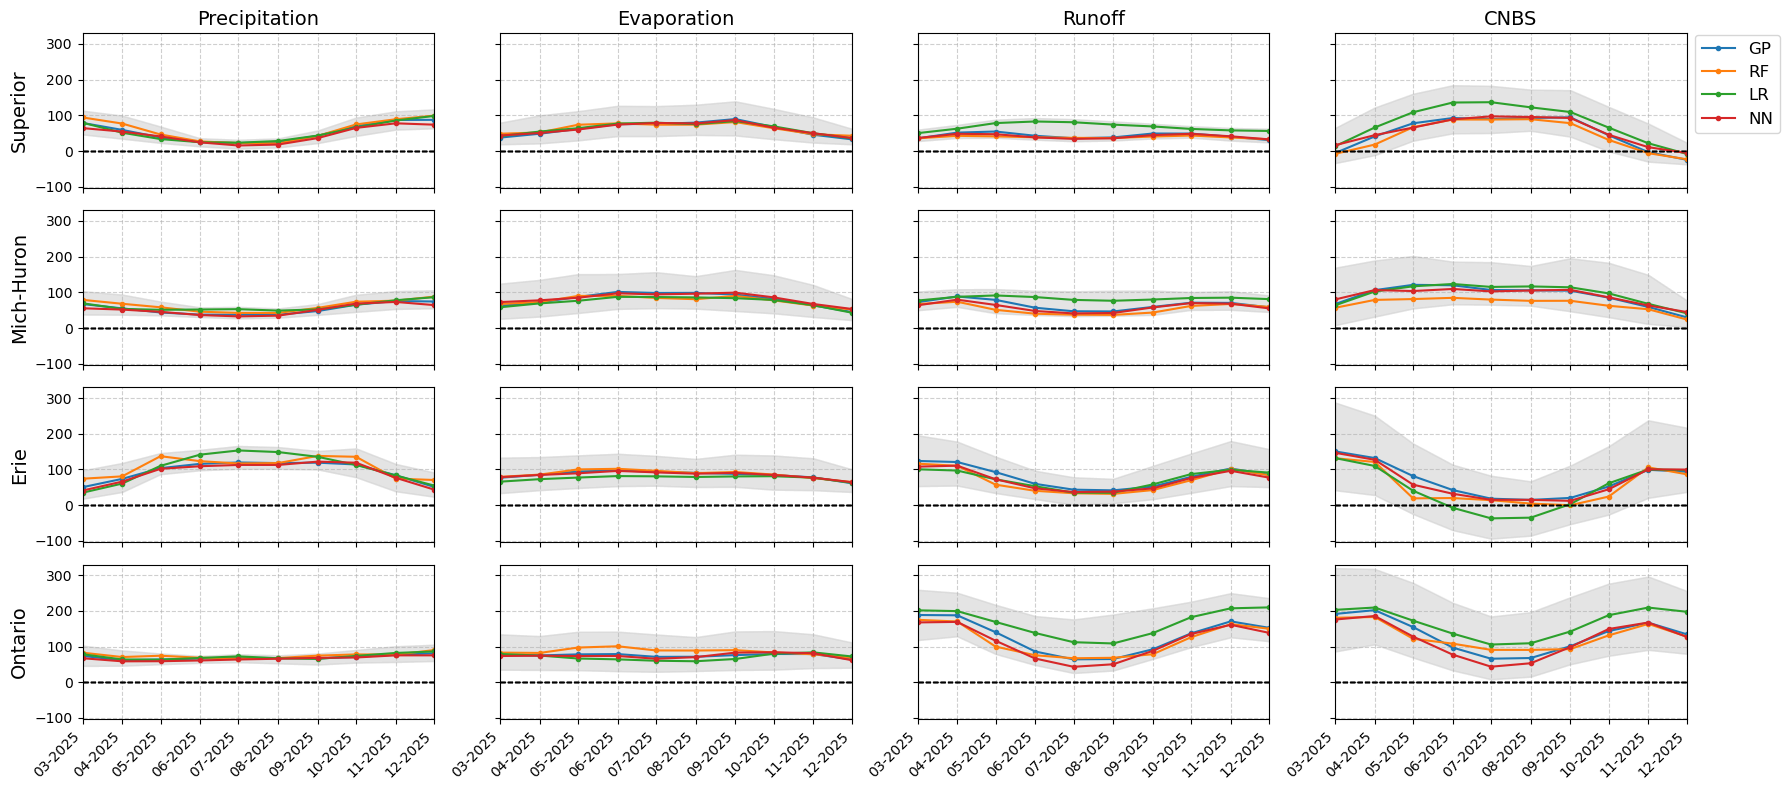

In [ ]:
# Columns of interest in the order we want to plot them
columns = ['superior_evaporation', 'superior_precipitation', 'superior_runoff', 'superior_cnbs',
           'michigan-huron_evaporation', 'michigan-huron_precipitation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
           'erie_evaporation', 'erie_precipitation', 'erie_runoff', 'erie_cnbs',
           'ontario_evaporation', 'ontario_precipitation', 'ontario_runoff', 'ontario_cnbs']

# Create a 1x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(18, 8))

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes. This will update in the loop 

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index (integer division by 4)
    col = i % 4   # Column index (remainder after division by 4)

    lower_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_name, df in model_predictions.items():
        # Get the grouped DataFrame for the current model
        median_df = df.groupby(['year', 'month']).median().round(3)

        # Add a 'date' column to the median DataFrame
        median_df = median_df.reset_index()
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Plot the medians for the current dataset on the same subplot
        axs[row, col].plot(median_df['date'], median_df[column], marker='o', markersize=3, label=model_name)

        # Add the shaded region (confidence band)
        axs[row, col].fill_between(median_df['date'], lower_bound[column], upper_bound[column], color='lightgray', alpha=0.2)
        axs[row, col].axhline(0, color='black', linestyle='--', linewidth=1) # Add a dashed line on 0
        axs[row, col].grid(True, linestyle='--', alpha=0.6) # Turn on a grid
        axs[row, col].set_yticks(np.arange(-1000, 1000, 100)) # Force y ticks on every 100

        # Update the global y-axis limits based on the current dataset
        # This allows us to set a y min and y max that is the same for all of the figures at the end
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set titles based on row and column
    if row == 0:
        axs[row, col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'CNBS'][col], fontsize=14)
    else:
        axs[row, col].set_title('')

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y')) # Format the dates on the x axis
        axs[row, col].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
        for label in axs[row, col].get_xticklabels(): # Position the labels
            label.set_horizontalalignment('right')
    else:
        axs[row, col].set_xticklabels([]) # Turn off x axis labels on all of the plots but the bottom row

    # Set y-axis labels for the first column only
    if col == 0:
        axs[row, col].set_ylabel(['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], fontsize=14)
    else:
        axs[row, col].set_yticklabels([]) # Turn off titles 

# Set consistent y-axis limits across all subplots
for row in range(4):
    for col in range(4):
        axs[row, col].set_ylim(global_y_min - 10, global_y_max + 10)
        axs[row, col].set_xlim(median_df['date'].iloc[0], median_df['date'].iloc[-1])

# Position the legend outside the plot area to the right
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3),fontsize=12)

# Save the figure as a PNG file
plt.savefig(f'{dir}forecast/CNBS_forecasts.png')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
